## Image Clustering

We want to cluster images so we can better understand the different kinds of images we're training on. We should:

1. Resize the images to 32x32x3
2. Run PCA on the images
3. Run K-Means clustering on the images
4. Visualize the clusters (adjust K)


### Resize Images

In [106]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from PIL import Image
from resizeimage import resizeimage
import os
from tqdm import tqdm, tnrange
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [19]:
path = '/home/josh/git/CancerDetection/data'

In [20]:
train_images = os.listdir(path + '/train')

In [22]:
os.mkdir(path + '/train_32/')

for filename in tqdm(train_images):
    loadPath = path + '/train/' + filename
    savePath = path + '/train_32/' + filename

    with open(loadPath, 'r+b') as f:
        with Image.open(f) as image:
            cover = resizeimage.resize_thumbnail(image, [32, 32])
            cover.save(savePath, image.format)

100%|██████████| 220025/220025 [02:41<00:00, 1365.51it/s]


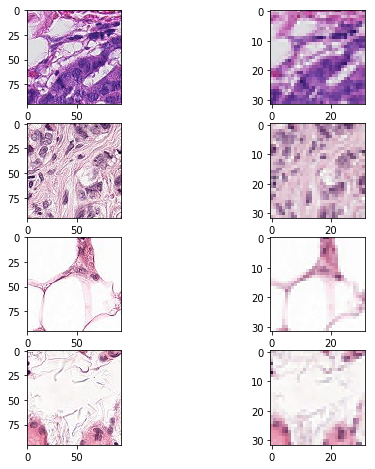

In [42]:
#Let's take a look at the images

fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 4

for i in range(0, rows):
    filename = train_images[i]
    originalPath = path + '/train/' + filename
    newPath = path + '/train_32/' + filename
        
    img1 = mpimg.imread(originalPath)
    img2 = mpimg.imread(newPath)
    fig.add_subplot(rows, columns, (i * 2) + 1)
    plt.imshow(img1)
    fig.add_subplot(rows, columns, (i * 2) + 2)
    plt.imshow(img2)
    
plt.show()    

### PCA

Now that our images are resized from `96x96x3 (27,648)` to `32x32x3 (3,072)` we want to run PCA against them.

In [116]:
from sklearn.decomposition import IncrementalPCA

In [117]:
chunkSize = 25000
chunk = np.zeros((chunkSize, 32 * 32 * 3))
numberOfImages = len(train_images)
numberOfChunks = int(((numberOfImages - 1) / chunkSize) + 1)

pca = IncrementalPCA(n_components=1000)

for i in tnrange(numberOfChunks):
    lowBound = i * chunkSize
    highBound = min(numberOfImages - 1, ((i+1) * chunkSize))
    
    j = 0
    for filename in train_images[lowBound:highBound]:
        imagePath = path + '/train_32/' + filename
        img=mpimg.imread(imagePath)
        img.resize((32 * 32 * 3))
        chunk[j] = img
        j = j + 1

    pca.fit(chunk)

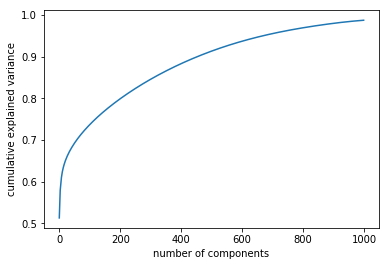

In [119]:
#Plot explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Now that we have fit PCA to our dataset, let's go through and transform all of our vectors into their PCA-ed version.

In [120]:
chunk = np.zeros((chunkSize, 32 * 32 * 3))
#pca_chunk = np.zeros((chunkSize, 1000))

numberOfImages = len(train_images)
numberOfChunks = int(((numberOfImages - 1) / chunkSize) + 1)

for i in tnrange(numberOfChunks):
    lowBound = i * chunkSize
    highBound = min(numberOfImages - 1, ((i+1) * chunkSize))
    
    j = 0
    for filename in train_images[lowBound:highBound]:
        imagePath = path + '/train_32/' + filename
        img=mpimg.imread(imagePath)
        img.resize((32 * 32 * 3))
        chunk[j] = img
        j = j + 1
        
    pca_chunk = pca.transform(chunk)
    filename = "pca_chunk_" + str(i) + ".npy"
    print("Saving: ", filename)
    np.save(filename, pca_chunk)

Saving:  pca_chunk_0.npy
Saving:  pca_chunk_1.npy
Saving:  pca_chunk_2.npy
Saving:  pca_chunk_3.npy
Saving:  pca_chunk_4.npy
Saving:  pca_chunk_5.npy
Saving:  pca_chunk_6.npy
Saving:  pca_chunk_7.npy
Saving:  pca_chunk_8.npy


### K Means Clustering

In [134]:
from sklearn.cluster import KMeans
import pickle

In [122]:
model = KMeans(n_clusters=6, n_jobs=-1)

In [127]:
chunk0 = np.load('pca_chunk_0.npy')
chunk1 = np.load('pca_chunk_1.npy')
chunk2 = np.load('pca_chunk_2.npy')
chunk3 = np.load('pca_chunk_3.npy')
chunk4 = np.load('pca_chunk_4.npy')
chunk5 = np.load('pca_chunk_5.npy')
chunk6 = np.load('pca_chunk_6.npy')
chunk7 = np.load('pca_chunk_7.npy')


allChunks = np.vstack([chunk0,chunk1,chunk2,chunk3,chunk4,chunk5,chunk6,chunk7])

In [128]:
allChunks.shape

(200000, 1000)

In [130]:
%time model.fit(allChunks)

CPU times: user 17min 3s, sys: 13.3 s, total: 17min 17s
Wall time: 5min 16s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [136]:
## TODO: Use Elbow method to find optimal number of groups
# https://pythonprogramminglanguage.com/kmeans-elbow-method/

In [135]:
#Save model
filename = 'kmeans.pkl'
pickle.dump(model, open(filename, 'wb'))

## Look at the clusters

In [139]:
pickle_file = open('kmeans.pkl', 'rb')
model = pickle.load(pickle_file)

In [159]:
imageLookup = [ [] for _ in range(6) ]

for filename in train_images[:36]:
    imagePath = path + '/train_32/' + filename
    img=mpimg.imread(imagePath)
    img.resize((32 * 32 * 3))
    
    transformed = pca.transform(np.expand_dims(img, axis=0))
    group = model.predict(transformed)
    imageLookup[group[0]].append(imagePath)   

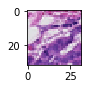

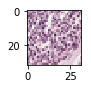

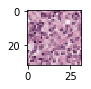

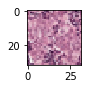

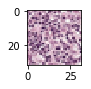

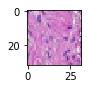

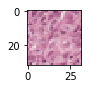

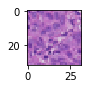

In [189]:
for imagePath in imageLookup[5]:
    pil_im = Image.open(imagePath, 'r')
    plt.figure(figsize=(1, 1))
    plt.imshow(np.asarray(pil_im))